# A comparison of stochastic methods for short-term wind energy forecasts

To achieve sustainability goals, "during the last years the production of wind energy has played an increasingly important role as a renewable energy source" (Benth et al. 2018). However, the accurate forecasting of wind power generation is challenging, as they are highly dependend on wind speed patterns which are the result of complex and multi-scale interactions in the atmosphere. Even more so, if the aim is an accurate forecast of the infeed of wind turbines, which can be considered as a prerequisite for the proper quantitative pricing and hedging of Green Power Purchase Agreements (PPAs). In this study the uncertainty of short-term wind power predictions is investigated with a special focus  on the role of the choice of stochastic models for wind speed. In particular, the evaluation of simulated wind power generation at several locations of wind turbines with a more detailed evaluation of the forecast for a particular location in xxx during the month/year xxx is combined. Four stochastic models are evaluated. In a first part, a comparison of ENTSOE data aggregated for Germany/the region xxx is used to evaluate the performance of the models, while, in a second part, data from a single wind turbine at xxx is used for a more detailed evaluation of the wind generation patterns. The analysis focuses on... . It is shown that ...

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

### ERA5 reanalysis data from ECMWF

Product type:Reanalysis

Variable:100m u-component of wind, 100m v-component of wind, 10m u-component of wind, 10m v-component of wind

Year:2021, 2022, 2023

Month:January, February, March, April, May, June, July, August, September, October, November, December

Day:01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31

Time:00:00, 01:00, 02:00, 03:00, 04:00, 05:00, 06:00, 07:00, 08:00, 09:00, 10:00, 11:00, 12:00, 13:00, 14:00, 15:00, 16:00, 17:00, 18:00, 19:00, 20:00, 21:00, 22:00, 23:00

Sub-region extraction:North 55°, West 6°, South 47°, East 15°

Format:NetCDF (experimental)

c:\Users\Anwender\.conda\envs\rivapy\lib\site-packages\gribapi\__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.23.0
  warnings.warn(


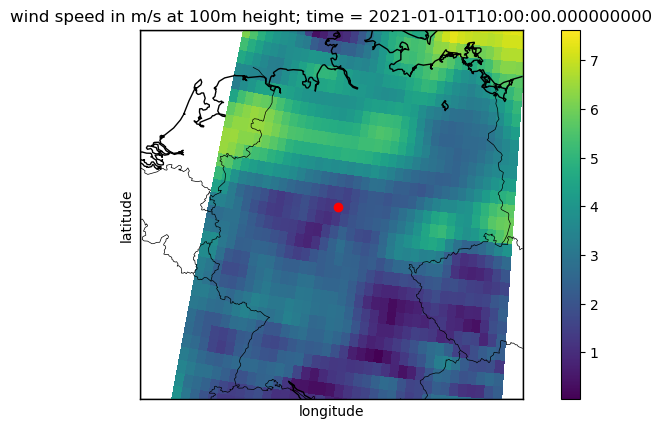

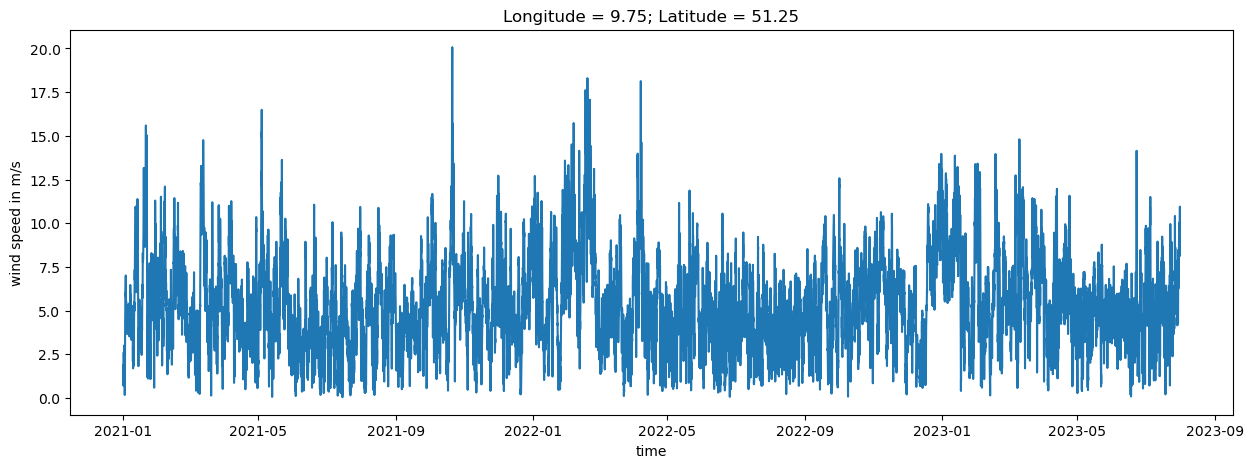

In [2]:
f=xr.open_dataset('C:/Users/Anwender/Documents/GitHub/RiVaPy_development/ERA5_Data_netCDF/adaptor.mars.internal-1698057309.422591-30637-3-8c127153-a2da-4e09-9756-06435d022dfb.nc')


lons = f.variables['longitude'][:]  # longitude
lats = f.variables['latitude'][:]  # latitude
u100 = f.variables['u100'][:,0,:,:] # u-wind at 100m height
v100 = f.variables['v100'][:,0,:,:]  # v-wind at 100m height
u10 = f.variables['u10'][:,0,:,:]  # u-wind at 10m height
v10 = f.variables['v10'][:,0,:,:]  # v-wind at 10m height
time = f.variables['time'][:]

ws100 = np.sqrt(u100*u100+v100*v100)
ws10 = np.sqrt(u10*u10+v10*v10)

m = Basemap(llcrnrlon=5,llcrnrlat=47,urcrnrlon=15,urcrnrlat=55,
             resolution='i', projection='tmerc', lat_0 = 80, lon_0 = 20)

lon, lat = np.meshgrid(lons, lats)
xi, yi = m(lon, lat)

#oick location
loc1 = 15

x1,y1 = m(lon[loc1,loc1], lat[loc1,loc1])


cs = m.pcolor(xi,yi,np.squeeze(ws100[10,:,:]))

m.drawcoastlines()
m.drawmapboundary()
m.drawcountries()
cbar = m.colorbar(cs, location='right', pad="10%")
tt = np.array(time[10])
plt.title('wind speed in m/s at 100m height; time = '+str(tt))
plt.xlabel('longitude')
plt.ylabel('latitude')
#plt.plot(xi[lon1,lon1], yi[lat1,lat1],'ro')
plt.plot(x1, y1,'ro')
plt.show()


plt.figure(figsize=(15,5))
plt.plot(time[:],ws100[:,loc1,loc1])
sel_lon = np.array(lons[loc1])
sel_lat = np.array(lats[loc1])
plt.title('Longitude = '+str(sel_lon)+'; Latitude = '+str(sel_lat))
plt.ylabel('wind speed in m/s')
plt.xlabel('time')
plt.show()


# Brown et al. 1984: Time series models to forecast wind speed and wind power

### Autoregressives Modell 1.Ordnung?



x(t+1)  = a * x(t) + e


(2.080294249026404, 0, 5.878695082058485)


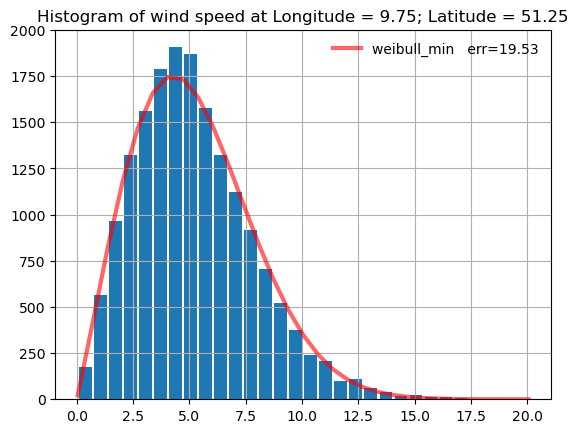

In [6]:
import scipy.stats as s

N=30
x1 = ws100[0:2*24*365,loc1,loc1]
counts, bins = np.histogram(x1, bins=N)
bin_width = bins[1]-bins[0]
total_count = float(sum(counts))

f, ax = plt.subplots(1, 1)

ax.bar(bins[:-1]+bin_width/2., counts, align='center', width=.85*bin_width)
ax.grid('on')
def fit_pdf(x, name='weibull_min', color='r'):
    dist = getattr(s, name)  # params = shape, loc, scale
    params = s.weibull_min.fit(x, floc=0)  # 1-day lag minimum for shipping
    print(params)
    y = dist.pdf(bins, *params)*total_count*bin_width
    sqerror_sum = np.log(sum(ci*(yi - ci)**2. for (ci, yi) in zip(counts, y)))
    ax.plot(bins, y, color, lw=3, alpha=0.6, label='%s   err=%3.2f' % (name, sqerror_sum))
    return y

colors = ['r-', 'g-', 'r:', 'g:']

for name, color in zip(['weibull_min'], colors): # 'lognorm', 'erlang', 'chi2', 'weibull_min', 
    y = fit_pdf(x1, name=name, color=color)

ax.legend(loc='best', frameon=False)
sel_lon = np.array(lons[loc1])
sel_lat = np.array(lats[loc1])
plt.title('Histogram of wind speed at '+'Longitude = '+str(sel_lon)+'; Latitude = '+str(sel_lat))
plt.show()

[<xarray.Variable ()>
array(-1.15896323e-10), <xarray.Variable ()>
array(1.22387795e-09), <xarray.Variable ()>
array(1.35346785e-09), <xarray.Variable ()>
array(-6.80287066e-10), <xarray.Variable ()>
array(-2.04245812e-10), <xarray.Variable ()>
array(-1.02202752e-10), <xarray.Variable ()>
array(-5.23789102e-11), <xarray.Variable ()>
array(1.18746822e-09), <xarray.Variable ()>
array(-5.0670208e-10), <xarray.Variable ()>
array(1.40397038e-09), <xarray.Variable ()>
array(1.12423027e-09), <xarray.Variable ()>
array(1.80962747e-09), <xarray.Variable ()>
array(-3.1124306e-10), <xarray.Variable ()>
array(-1.84559805e-09), <xarray.Variable ()>
array(1.66378894e-09), <xarray.Variable ()>
array(9.87214704e-10), <xarray.Variable ()>
array(-1.34300803e-10), <xarray.Variable ()>
array(-4.2861279e-10), <xarray.Variable ()>
array(5.49659174e-10), <xarray.Variable ()>
array(2.00732592e-10), <xarray.Variable ()>
array(-6.66553571e-10), <xarray.Variable ()>
array(8.99783444e-10), <xarray.Variable ()>
ar

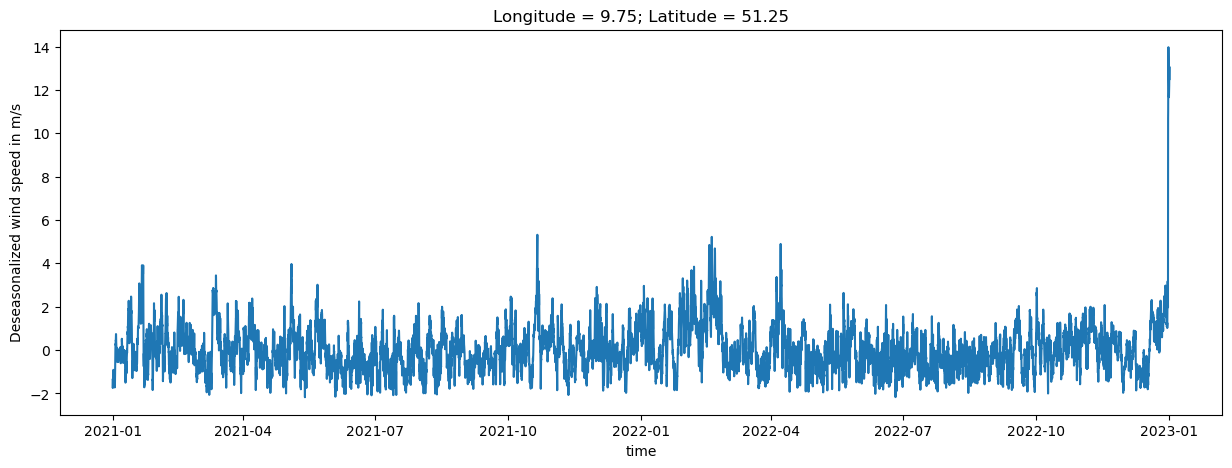

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


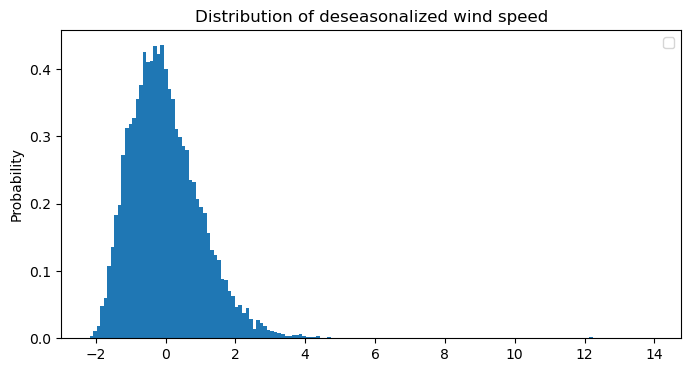

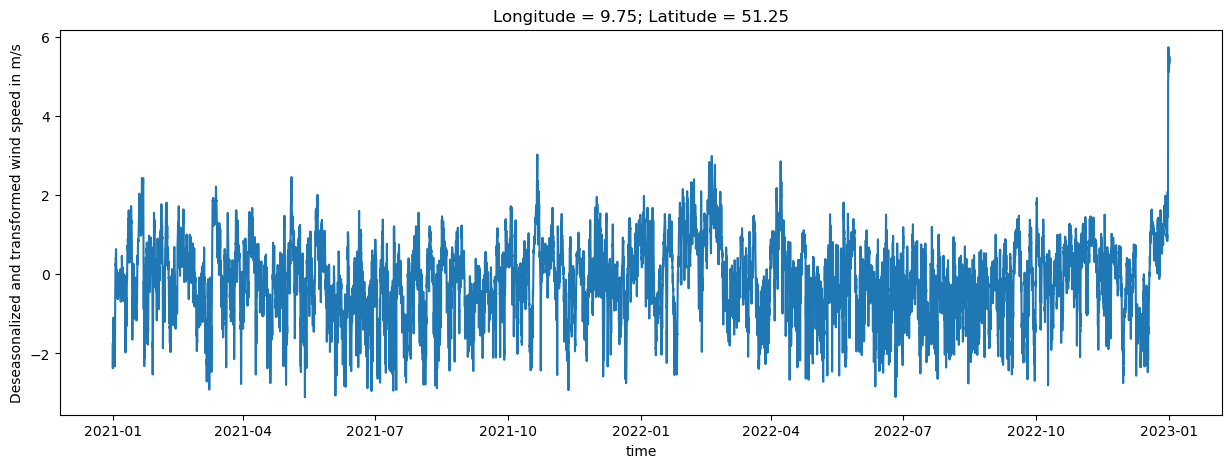

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


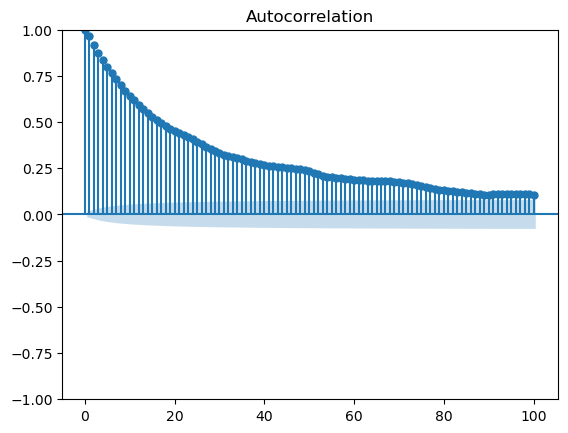

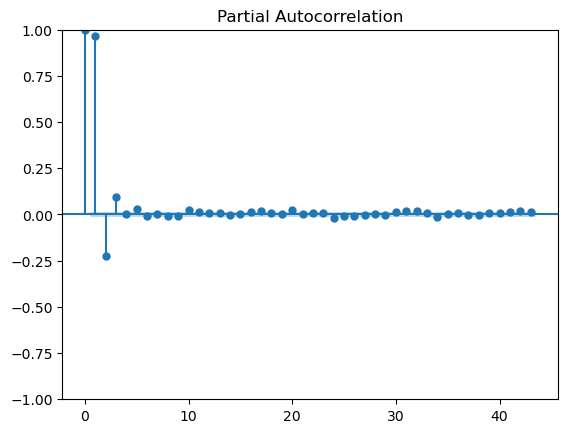

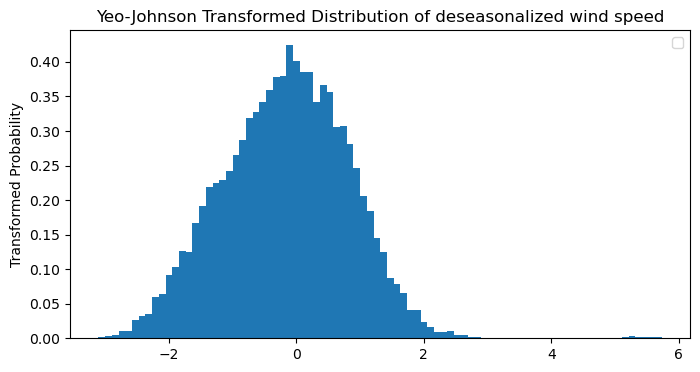

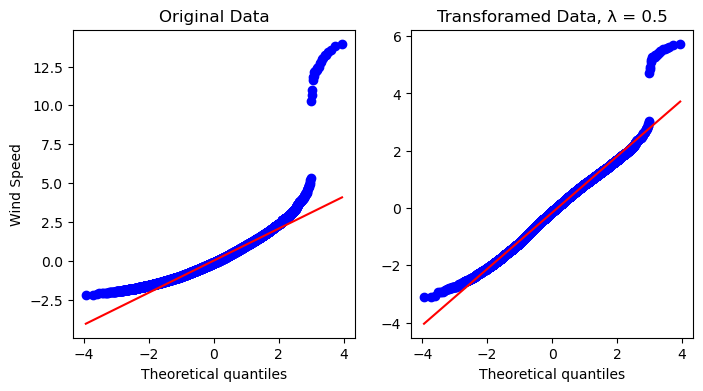

In [10]:
# statistical overview over distribution of wind time series
N=30
x1 = ws100[0:2*24*365,loc1,loc1]
counts, bins = np.histogram(x1, bins=N)
bin_width = bins[1]-bins[0]
total_count = float(sum(counts))


def fit_pdf(x, name='weibull_min', color='r'):
    dist = getattr(s, name)  # params = shape, loc, scale
    params = s.weibull_min.fit(x, floc=0)  # 1-day lag minimum for shipping
    #y = dist.pdf(bins, *params)*total_count*bin_width
    #sqerror_sum = np.log(sum(ci*(yi - ci)**2. for (ci, yi) in zip(counts, y)))
    #ax.plot(bins, y, color, lw=3, alpha=0.6, label='%s   err=%3.2f' % (name, sqerror_sum))
    return params

colors = ['r-', 'g-', 'r:', 'g:']

#for name, color in zip(['weibull_min'], colors): # 'lognorm', 'erlang', 'chi2', 'weibull_min', 
#    for i in range(33):
#        x1 = ws100[0:2*24*365,i,i]
#        params = fit_pdf(x1, name=name, color=color)
#        print(params)




# deseasonalization
mu = []
for i in range(0,24):
    mu.append(0)
    count = 0
    for j in range(i,len(x1)-24,24):
        mu[i] = mu[i] + x1[j]
        count = count + 1

    mu[i] = mu[i]/count


sigma = []
for i in range(0,24):
    sigma.append(0)
    count = 0
    for j in range(i,len(x1)-24,24):
        sigma[i] = sigma[i] + (x1[j] - mu[i])**2
        count = count + 1

    sigma[i] = np.sqrt(sigma[i]/count)

for i in range(0,24):
    for j in range(i,len(x1)-24,24):
        x1[j] = (x1[j] - mu[i])/sigma[i]


#box cox transformation (transform data to normal distribution)
from scipy.special import boxcox, inv_boxcox
x_trans = s.yeojohnson(x1,0.5)

xt = x_trans


plt.figure(figsize=(15,5))
plt.plot(time[0:2*24*365],xt)
sel_lon = np.array(lons[15])
sel_lat = np.array(lats[15])
plt.title('Longitude = '+str(sel_lon)+'; Latitude = '+str(sel_lat))
plt.ylabel('Deseasonalized and transformed wind speed in m/s')
plt.xlabel('time')
plt.show()


from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
#The autocorrelation function decays exponentially for an AR time series at a rate of the AR parameter.
plot_acf(xt,lags = 100)
#One useful tool to identify the order of an AR model is to look at the Partial Autocorrelation Function (PACF)
plot_pacf(xt)

# visual inspection

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(xt, bins='auto', density=True)
ax.set_ylabel('Transformed Probability')
ax.set_title('Yeo-Johnson Transformed Distribution of deseasonalized wind speed')
ax.legend();


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

prob = s.probplot(x1, dist=s.norm, plot=ax1)
prob = s.probplot(xt, dist=s.norm, plot=ax2)

ax1.set_title('Original Data')
ax1.set_ylabel('Wind Speed')
ax2.set_title('Transforamed Data, λ = 0.5');
ax2.set_ylabel('');
